## Project on discover images with cracking surface

In [226]:
# General
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import keras

# Path process
import os
import os.path
from pathlib import Path
import glob

# Image process
import cv2
from PIL import Image
from skimage.filters import sobel
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scale & transformation
from keras import regularizers
from sklearn.model_selection import RandomizedSearchCV
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

In [171]:
# Model Layers
from sklearn.neural_network import MLPClassifier
from keras import models
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

from keras import backend as K
from keras.models import load_model

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

#### Read images and creating DataFrame

In [3]:
path_neg = '/'.join([os.path.realpath('data'), 'Negative'])
path_pos = '/'.join([os.path.realpath('data'), 'Positive'])

neg_dir = Path(path_neg)
pos_dir = Path(path_pos)

In [4]:
def df_generate(img_dir, label):
    
    filepaths = pd.Series(list(img_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    
    return df

In [5]:
neg_df = df_generate(neg_dir, label='Negative')
pos_df = df_generate(pos_dir, label='Positive')

full_df = pd.concat([pos_df, neg_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
full_df

,Filepath,Label
0,D:\DataScience\Coursera\Neural Networks\Projec...,Positive
1,D:\DataScience\Coursera\Neural Networks\Projec...,Positive
2,D:\DataScience\Coursera\Neural Networks\Projec...,Positive
3,D:\DataScience\Coursera\Neural Networks\Projec...,Negative
4,D:\DataScience\Coursera\Neural Networks\Projec...,Positive
...,...,...
39995,D:\DataScience\Coursera\Neural Networks\Projec...,Positive
39996,D:\DataScience\Coursera\Neural Networks\Projec...,Negative
39997,D:\DataScience\Coursera\Neural Networks\Projec...,Positive
39998,D:\DataScience\Coursera\Neural Networks\Projec...,Positive


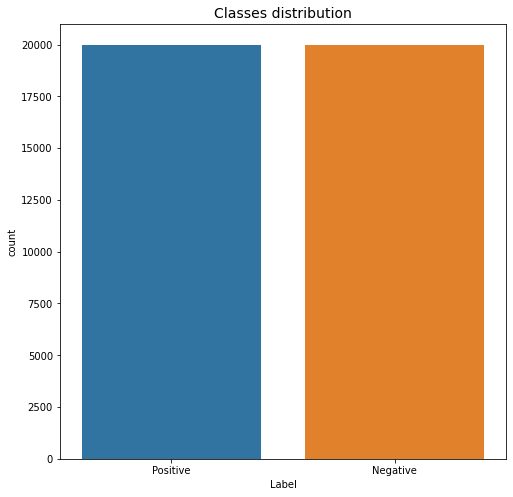

In [126]:
plt.figure(figsize=(8,8));
sns.countplot(full_df.Label);

plt.title('Classes distribution', fontsize=14);

In [7]:
image_height = 128
image_width = 128

#### Visualisation

In [9]:
def vision_simple(path):
    '''original image visualisation'''
    
    reading_img = cv2.imread(path)
    
    return reading_img

In [12]:
def threshold_vision(path):
    '''image with global thresholding technique'''
    
    thres = 90
    max_val = 255
    
    reading_img = cv2.imread(path)
    reading_img_gr = cv2.cvtColor(reading_img, cv2.COLOR_BGR2GRAY)
    
    _, th_img = cv2.threshold(reading_img_gr, thres, max_val, cv2.THRESH_BINARY)
    
    return th_img

In [13]:
def canny_filter(path):
    '''image with edge detection'''
    
    t_lower = 50
    t_upper = 90
    
    reading_img = cv2.imread(path)
    reading_img_gr = cv2.cvtColor(reading_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(reading_img_gr, (9,9), 30)
    canny_img = cv2.Canny(blur, t_lower, t_upper, apertureSize=3, L2gradient=True)
    
    return canny_img

In [138]:
titles = ['Original Image', 'Global Thresholding','Canny filtering']
images = full_df.sample(21, random_state=29)

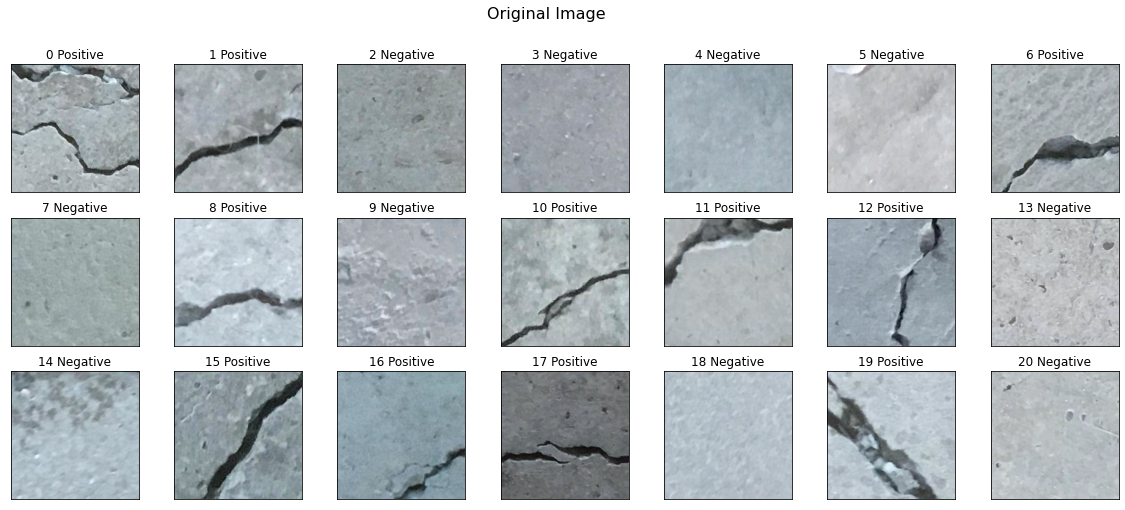

In [146]:
plt.figure(figsize=(20,8))

for i in range(len(images)):
    plt.subplot(3,7, i+1)
    img = images.iloc[i][0]
    labl = images.iloc[i][1]
    plt.imshow(vision_simple(img))
    
    plt.title(str(i) + ' ' +labl)
    plt.xticks([]),plt.yticks([])

plt.suptitle('Original Image', fontsize=16)
plt.show()

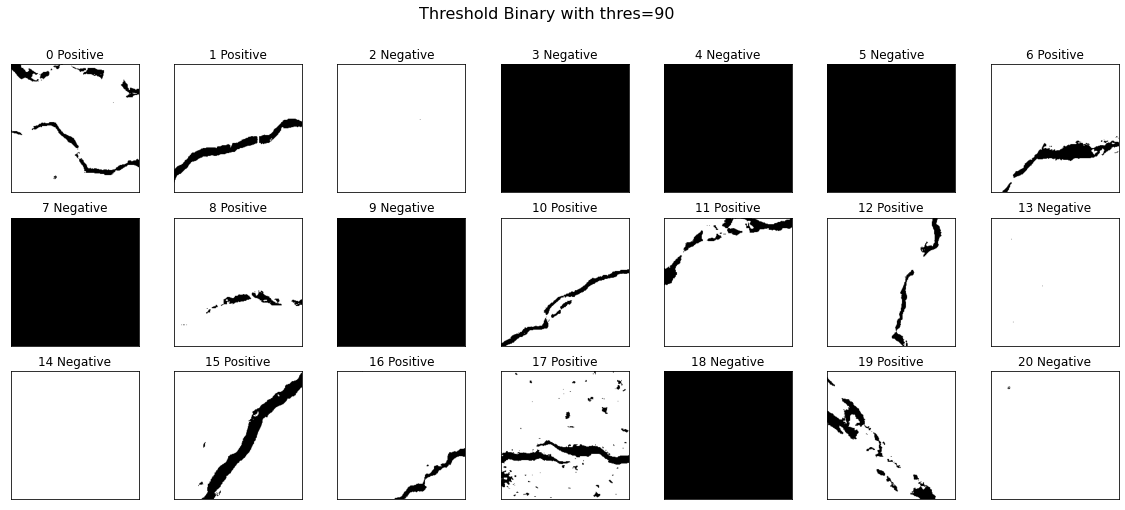

In [147]:
plt.figure(figsize=(20,8))


for i in range(len(images)):
    plt.subplot(3,7, i+1)
    img = images.iloc[i][0]
    labl = images.iloc[i][1]
    plt.imshow(threshold_vision(img), cmap=plt.cm.gray)
    
    plt.title(str(i) + ' ' +labl)
    plt.xticks([]),plt.yticks([])

plt.suptitle('Threshold Binary with thres=90', fontsize=16)
plt.show()

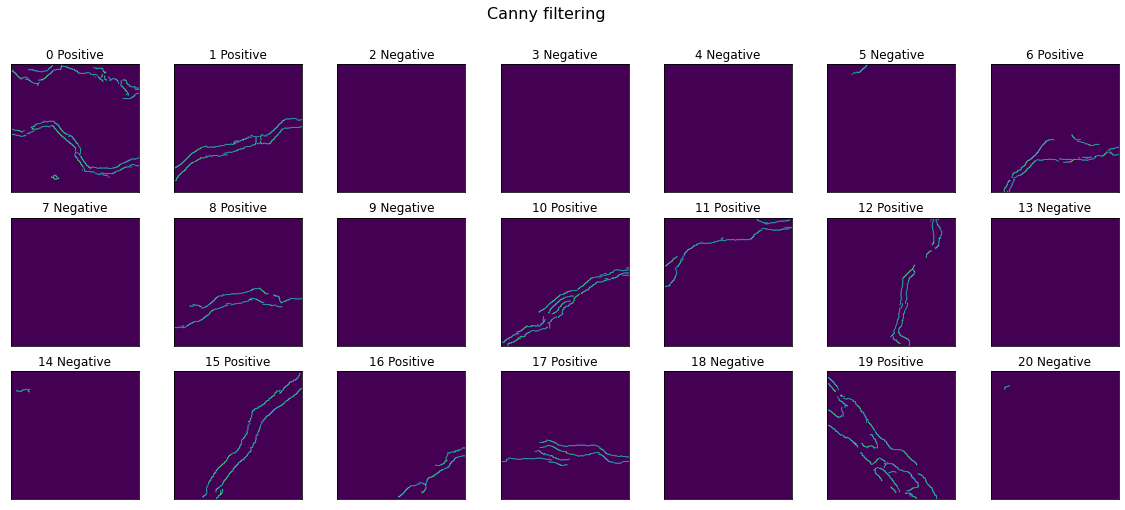

In [145]:
plt.figure(figsize=(20,8))

for i in range(len(images)):
    plt.subplot(3,7, i+1)
    img = images.iloc[i][0]
    labl = images.iloc[i][1]
    plt.imshow(canny_filter(img))
    
    plt.title(str(i) + ' ' +labl)
    plt.xticks([]),plt.yticks([])

plt.suptitle('Canny filtering', fontsize=16)
plt.show()

### Divide dataset into train and test sets

In [218]:
train_df, test_df = train_test_split(full_df.sample(6000, random_state=1), test_size=0.3, shuffle=True, random_state=25)

#### Load Images

In [219]:
train_gen = ImageDataGenerator(rescale=1./255,
                               validation_split=0.2)

test_gen = ImageDataGenerator(rescale=1./255)

In [220]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_height, image_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_height, image_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_height, image_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


### CNN Model Training

In [221]:
inputs = tf.keras.Input(shape=(image_height, image_width, 1))

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")


print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0   

In [222]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=15,
                    callbacks=[Early_Stopper, Checkpoint_Model])

Epoch 1/15
105/105 [==============================] - 65s 616ms/step - loss: 0.3723 - accuracy: 0.9247 - val_loss: 0.6904 - val_accuracy: 0.5107
Epoch 2/15
105/105 [==============================] - 65s 617ms/step - loss: 0.0350 - accuracy: 0.9887 - val_loss: 0.6842 - val_accuracy: 0.5357
Epoch 3/15
105/105 [==============================] - 66s 625ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 0.5151 - val_accuracy: 0.8786
Epoch 4/15
105/105 [==============================] - 65s 620ms/step - loss: 0.0398 - accuracy: 0.9866 - val_loss: 0.2928 - val_accuracy: 0.9869
Epoch 5/15
105/105 [==============================] - 64s 614ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 0.1950 - val_accuracy: 0.9869
Epoch 6/15
105/105 [==============================] - 65s 614ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.1024 - val_accuracy: 0.9917
Epoch 7/15
105/105 [==============================] - 64s 614ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.0489 - val_ac

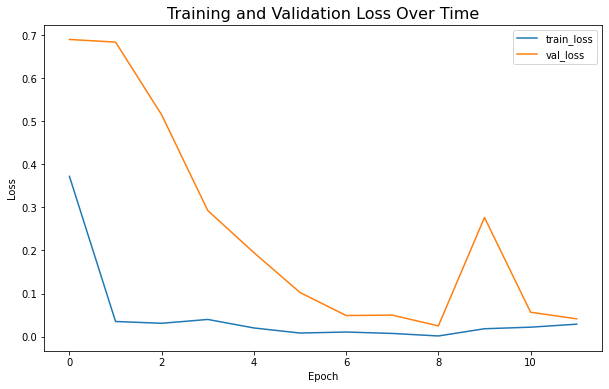

In [223]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss Over Time', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#### Evaluating model

    Test Loss: 0.02455
Test Accuracy: 99.44%


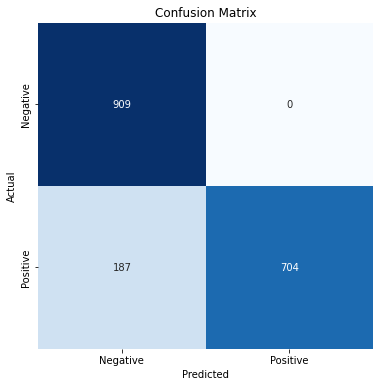

Classification Report:
----------------------
               precision    recall  f1-score   support

    Negative       0.83      1.00      0.91       909
    Positive       1.00      0.79      0.88       891

    accuracy                           0.90      1800
   macro avg       0.91      0.90      0.89      1800
weighted avg       0.91      0.90      0.89      1800



In [224]:
# Evaluate the model

results = model.evaluate(test_data, verbose=0)
loss_cnn = results[0]
acc_cnn = results[1]

print("    Test Loss: {:.5f}".format(loss_cnn))
print("Test Accuracy: {:.2f}%".format(acc_cnn * 100))

y_pred = np.squeeze((model.predict(test_data)).astype('int32'))

cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["Negative", "Positive"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [232]:
_, _, fbeta_score_cnn, _ = precision_recall_fscore_support(test_data.labels, y_pred, average='binary')

In [225]:
mistake_idx = (y_pred != test_data.labels).nonzero()[0]
print(len(mistake_idx), "mistakes.")

187 mistakes.


### Feature engeneering with Thresholding Binary technique and applying Sobel filter

In [29]:
small_df = full_df.sample(6000, random_state=1)

In [103]:
#Capture images and labels into arrays.
#Start by creating empty lists.
small_images = []
small_imag_sobel = []
small_im_canny = []
small_labels = []


for item in range(small_df.shape[0]):
    label = small_df.iloc[item][1]
    #print(label)
    img_path = small_df.iloc[item][0]
    #print(img_path)
    img_orig = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
    img = cv2.resize(img_orig, (image_height, image_width)) #Resize images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Change RGB to Grayscale
    img_sob = img.copy()
    
    small_images.append(img)
    small_labels.append(label)
    
    img_sob[(img_sob[:,:])>90] = 255
    small_imag_sobel.append(img_sob)


In [104]:
# Collect data into dataframe

df_1 = pd.DataFrame()
df_1['Original_img'] = small_images
df_1['Sobel_img'] = small_imag_sobel

In [105]:
#Encode labels from text (folder names) to integers.

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(small_labels)
small_labels_encoded = le.transform(small_labels)

In [106]:
#Split data into test and train datasets

x_train, x_test, y_train, y_test = train_test_split(df_1, small_labels_encoded, test_size=0.3, shuffle=True, random_state=42)

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [148]:
print(f'x_train size is {x_train.shape[0]} images')
print(f'x_test size is {x_test.shape[0]} images')

x_train size is 4200 imges
x_test size is 1800 imges


In [107]:
x_train = np.array(x_train)
x_test = np.array(x_test)

### Feature Extraction

In [110]:
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
# Channels = 1 in this case

def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, 0]
        img = input_img
        
        input_img_sobel = x_train[image, 1]
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
        # FEATURE 1 - Pixel values
        
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        #df['Image_Name'] = image   #Capture image name as we read multiple images
        
         
        # FEATURE 2 Apply Sobel filtering
        
        edge_sobel = sobel(input_img_sobel)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [111]:
#Extract features from training images
image_features = feature_extractor(x_train)

In [112]:
#Reshape to a vector for CNN model
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_NN = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features

In [113]:
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_NN = np.reshape(test_features, (x_test.shape[0], -1))

In [114]:
model = MLPClassifier().fit(X_for_NN, y_train)
y_pred = model.predict(test_for_NN)

print(f"Using MLPClassifier with the default parameter values gives an accuracy of {accuracy_score(y_pred, y_test)}")

Using MLPClassifier with the default parameter values gives an accuracy of 0.9711111111111111


In [115]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       905
           1       0.96      0.98      0.97       895

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [116]:
parameters = {'hidden_layer_sizes':[200, 300, 400],
              'alpha': [0.01, 0.1], 
              'max_iter': [200, 500], 
              'learning_rate_init':[0.001, 0.01, 0.1]}

model = MLPClassifier()
clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, cv=5)
clf.fit(X_for_NN, y_train) # reduce the train set size to shorten the training time

print("The best parameter values found are:\n")
print(clf.best_params_)

# store the best model found in "bestmodel"
bestmodel = clf.best_estimator_

The best parameter values found are:

{'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': 200, 'alpha': 0.01}


In [117]:
y_pred = bestmodel.predict(test_for_NN)

The accuracy score of the best model is 0.9772222222222222



In [152]:
# Accuracy score for MLPClassifier

acc_MLPC = accuracy_score(y_test, y_pred)

In [156]:
print("Classification Report:\n----------------------\n")
print(classification_report(y_pred, y_test, target_names=["Negative", "Positive"]))

Classification Report:
----------------------

              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       884
    Positive       0.98      0.98      0.98       916

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



The Test Accuracy: 97.72%


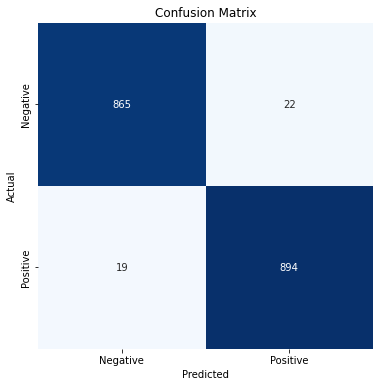

In [155]:
print("The Test Accuracy: {:.2f}%".format(acc_MLPC * 100))
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [149]:
y_pred_MLPC = y_pred

In [233]:
 _, _, fbeta_score_MLPC, _ = precision_recall_fscore_support(y_test, y_pred_MLPC, average='binary')

### VGG16-based transfer learning model

#### Preparing the data subsets for transfer learning

In [183]:
train_data_vgg = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_height, image_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_vgg = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_height, image_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_vgg = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_height, image_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [159]:
from keras.applications import vgg16

In [182]:
# load the VGG16 architecture with imagenet weights as base
vgg = vgg16.VGG16(
                 include_top = False,
                 weights = 'imagenet',
                 input_shape = (image_height, image_width, 3)
                 )

In [161]:
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [162]:
# Freeze the basemodel, like the lower layers
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

In [163]:
# Create a new model on top
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [164]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 4,457,985
Non

In [174]:
# Compile the model
model.compile(loss ='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics = ['accuracy'])

In [175]:
# use early stopping to avoid over-training the model
# An over-trained model overfits the training dataset and has poor performance on unseen test sets.
# We will also use a exponential step-decay based learning rate scheduler.

from keras.callbacks import LearningRateScheduler
checkpoint_path='O_R_tlearn_image_augm_cnn_vgg16.h5'

# define step decay function
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

#### Fit and train the model

In [185]:
extract_feat_model = model.fit(train_data_vgg, 
                              steps_per_epoch=10, 
                              epochs=5,
                              validation_data=val_data_vgg, 
                              validation_steps=10, 
                              verbose=1,
                              callbacks = callbacks_list_)

Epoch 1/5
10/10 [==============================] - 17s 2s/step - loss: 89808.2656 - accuracy: 0.5938 - val_loss: 326.6169 - val_accuracy: 0.9469 - lr: 0.1000
Epoch 2/5
10/10 [==============================] - 18s 2s/step - loss: 376.2718 - accuracy: 0.9250 - val_loss: 49.4946 - val_accuracy: 0.9812 - lr: 0.0905
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 66.7170 - accuracy: 0.9688 - val_loss: 48.4040 - val_accuracy: 0.9844 - lr: 0.0819
Epoch 4/5
10/10 [==============================] - 18s 2s/step - loss: 23.1178 - accuracy: 0.9937 - val_loss: 12.7950 - val_accuracy: 0.9875 - lr: 0.0741
Epoch 5/5
10/10 [==============================] - 18s 2s/step - loss: 109.0787 - accuracy: 0.9594 - val_loss: 43.7910 - val_accuracy: 0.9875 - lr: 0.0670


In [186]:
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_image_augm_cnn_vgg16.h5')

In [187]:
# Convert likelihood values into class labels

num2class_lt = lambda l: [0 if x < 0.5 else 1 for x in l]

In [188]:
# predictions on the test dataset

predictions_extract_feat_model = extract_feat_model.predict(test_data_vgg, verbose=0)

In [189]:
# convert predictions into binary classes

predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)

In [190]:
print("Classification Report:\n----------------------\n")
print(classification_report(test_data_vgg.labels, predictions_extract_feat_model))

Classification Report:
----------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       887
           1       0.99      1.00      0.99       913

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [192]:
result_vgg = extract_feat_model.evaluate(test_data_vgg, verbose=0)
loss = result_vgg[0]
acc = result_vgg[1]

The Test Accuracy: 99.06%


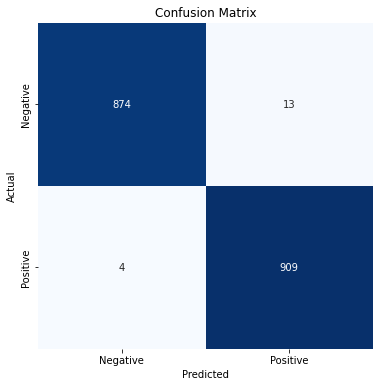

In [194]:
print("The Test Accuracy: {:.2f}%".format(acc * 100))

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, predictions_extract_feat_model), annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [201]:
y_test_vgg = test_data_vgg.labels.copy()
y_pred_vgg = predictions_extract_feat_model.copy()

In [202]:
y_test_vgg = np.array(y_test_vgg)
y_pred_vgg = np.array(y_pred_vgg)

In [234]:
 _, _, fbeta_score_vgg, _ = precision_recall_fscore_support(y_test_vgg, y_pred_vgg, average='binary')

In [203]:
mistake_idx = (y_pred_vgg != y_test_vgg).nonzero()[0]

In [204]:
mistake_df_vgg = pd.DataFrame(full_df, index=mistake_idx)

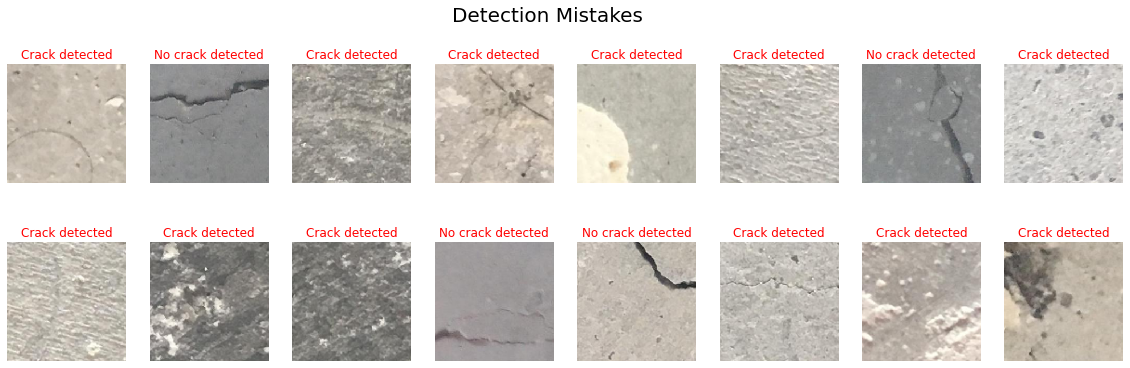

In [208]:
plt.figure(figsize=(20, 6))

for i, idx in enumerate(mistake_idx[0:16]):
    
    # Get batch number and image number (batch of 32 images)
    batch = idx // 32
    image = idx % 32
    
    plt.subplot(2, 8, i+1)
    plt.imshow(test_data_vgg[batch][0][image], cmap=plt.cm.gray)
    plt.title("No crack detected" if y_pred_vgg[idx] == 0 else "Crack detected", color='red')
    plt.axis('off')
    
plt.suptitle("Detection Mistakes", fontsize=20)
plt.show()

### Model comparison

In [235]:
accuracies = [acc_MLPC, acc_cnn, acc]
fbetas = [fbeta_score_MLPC, fbeta_score_cnn, fbeta_score_vgg]
acc_titles = ['MLPClassifier', 'CNN', 'VGG16-based model']

result_df = pd.DataFrame(accuracies, index=acc_titles, columns=['Test Accuracy'])
result_df['F1 score'] = fbetas

In [237]:
result_df.sort_values(by='F1 score', ascending=False)

,Test Accuracy,F1 score
VGG16-based model,0.990556,0.990736
MLPClassifier,0.977222,0.977583
CNN,0.994444,0.882759
